In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import time

import sys
sys.path.insert(0, '..')  # adds the root directory to the path

from policy_distillation.behaviour_clone import BCAgent, Transition, make_train
import matplotlib.pyplot as plt

# Meta-learning the Dataset

## Setup

In [10]:
from evosax import OpenES, ParameterReshaper

env_name = "Acrobot-v1"
env, env_params = gymnax.make(env_name)
env = FlattenObservationWrapper(env)
env = LogWrapper(env)

n_actions = env.action_space(env_params).n

config = {
    "LR": 5e-2,  # 5e-3      # 2.5e-2 to 5e-2 brings BC loss to ~0 for UPDATE_EPOCHS=10 and up to 100 states/action
    "NUM_ENVS": 16,   #8 # Num eval envs
    "NUM_STEPS": 512,   #128 # Max num eval steps per env
    "UPDATE_EPOCHS": 10,  # Num BC gradient steps
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "WIDTH" : 64,
    "ENV_NAME": env_name,
    "ANNEAL_LR": True,
    "GREEDY_ACT": True,  # Whether to use greedy act in env or sample
    "ENV_PARAMS" : {}
}

es_config = {
    "popsize": 500,  # Num of candidates
    "dataset_size": n_actions * 1, #10 #20000,  # Num of (s,a) pairs (split evenly across actions)
    "rollouts_per_candidate": 16,  #32 Num of BC policies trained per candidate
    "n_generations": 10,
    "log_interval": 1,
}

params = jnp.zeros(
    (es_config["dataset_size"], *env.observation_space(env_params).shape)
)
param_reshaper = ParameterReshaper(params)

rng = jax.random.PRNGKey(0)

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 18 parameters detected for optimization.


## Sampling real data

In [11]:
from tqdm import tqdm
# rng, reset_rng = jax.random.split(rng)
# obs, env_state = env.reset(reset_rng, env_params)

# obs_list = []
# action_list = []
# dones_list = []

# # Small chance of not gathering enough data, but it doesn't matter in practice
# for t in tqdm(range(es_config["dataset_size"] * 10)):
#     rng, rng_act, rng_step = jax.random.split(rng, 3)
#     action = jax.random.choice(rng_act, a=jnp.arange(n_actions))
#     action_list.append(action.item())
    
#     obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params)
#     obs_list.append(obs)    
    
# action_list = jnp.array(action_list)
# obs_list = jnp.array(obs_list)

# dataset = []
# for a in range(n_actions):
#     obs_for_action = obs_list[action_list == a]
#     rng, rng_shuffle = jax.random.split(rng)
#     dataset.append(jax.random.shuffle(rng_shuffle, obs_for_action, axis=0)[0:es_config["dataset_size"]//n_actions])
    
# sampled_data = jnp.array(dataset).flatten()
# print(sampled_data.shape)

# print(sampled_data.reshape(2,4))

## Initialize Strategy

In [12]:
# Initialize OpenES Strategy
# rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng)

strategy = OpenES(
    popsize=es_config["popsize"],
    num_dims=param_reshaper.total_params,
    opt_name="adam",
    maximize=True,
)

# Replace state mean with real observations
# state = state.replace(mean = sampled_data)

es_params = strategy.default_params
# es_params = es_params.replace(init_max=1.0)
state = strategy.initialize(rng_init, es_params)


def get_action_labels(d_size, n_actions):
    action_labels = jnp.array([i % n_actions for i in range(d_size)])
    action_labels = action_labels.sort()
    return action_labels


# Set up vectorized fitness function
train_fn = make_train(config)
action_labels = get_action_labels(es_config["dataset_size"], n_actions)


def single_seed_BC(rng_input, dataset):
    out = train_fn(dataset, action_labels, rng_input)
    return out  # ["metrics"]['returned_episode_returns'].mean()


multi_seed_BC = jax.vmap(single_seed_BC, in_axes=(0, None))  # Vectorize over seeds
train_and_eval = jax.jit(jax.vmap(multi_seed_BC, in_axes=(None, 0)))  # Vectorize over datasets

if len(jax.devices()) > 1:
    train_and_eval = jax.pmap(train_and_eval, in_axes=(None, 0))

## Run OpenES loop

In [13]:
start = time.time()
lap_start = start
fitness_over_gen = []
max_fitness_over_gen = []
for gen in range(es_config["n_generations"]):
    # Gen new dataset
    rng, rng_ask, rng_inner = jax.random.split(rng, 3)
    datasets, state = jax.jit(strategy.ask)(rng_ask, state, es_params)
    # Eval fitness
    batch_rng = jax.random.split(rng_inner, es_config["rollouts_per_candidate"])
    # Preemptively overwrite to reduce memory load
    out = None
    returns = None
    dones = None
    fitness = None
    shaped_datasets = None

    with jax.disable_jit(False):
        shaped_datasets = param_reshaper.reshape(datasets)
        out = train_and_eval(batch_rng, shaped_datasets)

        returns = out["metrics"]["returned_episode_returns"]  # dim=(popsize, rollouts, num_steps, num_envs)
        dones = out["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
        
        # Division by zero, you idiot
        fitness = (returns * dones).sum(axis=(-1, -2, -3)) / dones.sum(axis=(-1, -2, -3))  # fitness, dim = (popsize)
        fitness = fitness.flatten()    # Necessary if pmap-ing to 2+ devices

    # Update ES strategy with fitness info
    state = jax.jit(strategy.tell)(datasets, fitness, state, es_params)
    fitness_over_gen.append(fitness.mean())
    max_fitness_over_gen.append(fitness.max())

    if gen % es_config["log_interval"] == 0 or gen == 0:
        lap_end = time.time()
        if len(jax.devices()) > 1:
            bc_loss = out["metrics"]["bc_loss"][:,:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,:,-1]
        else:
            bc_loss = out["metrics"]["bc_loss"][:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,-1]
        
        print(
            f"Gen: {gen}, Fitness: {fitness.mean():.2f} +/- {fitness.std():.2f}, "
            + f"Best: {state.best_fitness:.2f}, BC loss: {bc_loss.mean():.2f} +/- {bc_loss.std():.2f}, "
            + f"BC acc: {bc_acc.mean():.2f} +/- {bc_acc.std():.2f}, Lap time: {lap_end-lap_start:.1f}s"
        )
        lap_start = lap_end
print(f"Total time: {(lap_end-start)/60:.1f}min")


Gen: 0, Fitness: -410.98 +/- 131.19, Best: -83.86, BC loss: 0.14 +/- 0.21, BC acc: 0.95 +/- 0.13, Lap time: 4.8s
Gen: 1, Fitness: -166.34 +/- 91.53, Best: -83.34, BC loss: 0.01 +/- 0.04, BC acc: 1.00 +/- 0.02, Lap time: 1.2s
Gen: 2, Fitness: -123.48 +/- 45.17, Best: -82.03, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.2s
Gen: 3, Fitness: -110.10 +/- 22.79, Best: -82.03, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.2s
Gen: 4, Fitness: -96.52 +/- 10.88, Best: -82.03, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.4s
Gen: 5, Fitness: -99.56 +/- 10.01, Best: -82.03, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.2s
Gen: 6, Fitness: -91.36 +/- 3.74, Best: -82.03, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.2s
Gen: 7, Fitness: -88.78 +/- 3.16, Best: -82.03, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.2s
Gen: 8, Fitness: -87.38 +/- 2.55, Best: -82.03, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.2s

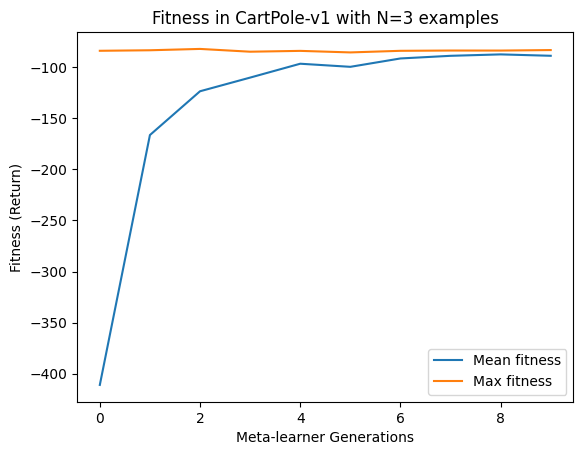

In [15]:
from scipy.signal import savgol_filter
# savgol_filter(y, 20, 3)

y = fitness_over_gen
plt.plot(fitness_over_gen, label="Mean fitness")
y = max_fitness_over_gen
plt.plot(max_fitness_over_gen, label="Max fitness")
plt.title(f"Fitness in CartPole-v1 with N={es_config['dataset_size']} examples")
plt.ylabel("Fitness (Return)")
plt.xlabel("Meta-learner Generations")
plt.legend()
plt.show()

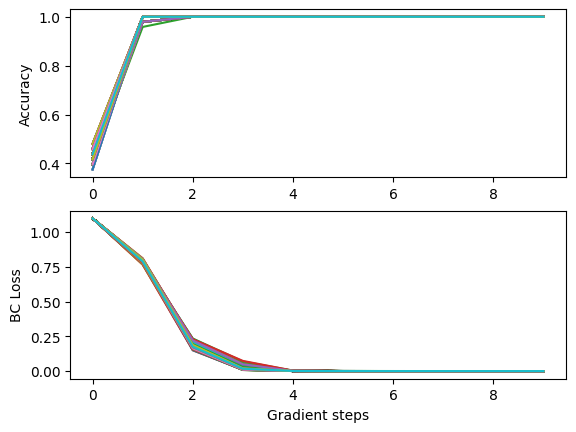

In [16]:
def reshape(arr):
    """Removes extra dim due to pmap"""
    dims = arr.shape
    arr = arr.reshape(-1,dims[-2],dims[-1])
    return arr

fig, ax = plt.subplots(2, 1)
for i in range(es_config["popsize"]):
    acc = reshape(out["metrics"]["bc_accuracy"])[i].mean(axis=0)
    ax[0].plot(acc)
    ax[0].set_ylabel("Accuracy")

    loss = reshape(out["metrics"]["bc_loss"])[i].mean(axis=0)
    ax[1].plot(loss)
    ax[1].set_ylabel("BC Loss")
    ax[1].set_xlabel("Gradient steps")

## Double check policy return

In [17]:
P = es_config["popsize"]
final_datasets_reshaped = param_reshaper.reshape(datasets)

best = fitness.argmax()

if len(jax.devices()) > 1:
    best_idx = (best // (P//2), best % (P//2))
else:
    best_idx = (best % (P//2))

final_dataset = final_datasets_reshaped[best_idx]

print("Final dataset:")
print(final_dataset)

Final dataset:
[[ 0.08898864 -0.04000862  0.18783423  0.26755854  0.25886902 -0.27246553]
 [-0.18179111  0.03961532 -0.4083058  -0.05957713 -0.02382991  0.12194284]
 [ 0.05496381  0.36941004  0.15743907 -0.25125855 -0.26081392  0.35848475]]


In [20]:
train_state = out["runner_state"][0]
# Note: if multiple rollouts / candidate, pick first rollout
if len(jax.devices()) > 1:
    f = lambda x : x[best_idx[0], best_idx[1], 0]
else:
    f = lambda x : x[best_idx, 0]
best_params = jax.tree_util.tree_map(f, train_state.params)

best_ret = returns[best_idx]
best_dones = dones[best_idx]

best_mean_ret  = (best_ret * best_dones).sum(axis=(-1, -2)) / best_dones.sum(axis=(-1, -2))
print("Best mean return per rollout", best_mean_ret)

Best mean return per rollout [-79.49462  -83.10113  -80.88889  -83.48276  -84.15295  -84.
 -80.933334 -85.505745 -84.068184 -87.89412  -83.45455  -83.41111
 -82.13187  -83.117645 -80.78022  -84.574715]


In [21]:
env, env_params = gymnax.make(config["ENV_NAME"])
env = FlattenObservationWrapper(env)
env = LogWrapper(env)

n_actions = env.action_space(env_params).n

rng = jax.random.PRNGKey(42)
rng, reset_rng = jax.random.split(rng)
obs, env_state = env.reset(reset_rng, env_params)

rewards_per_ep = []

for t in tqdm(range(512)):
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    
    pi = train_state.apply_fn(best_params, obs)
    action = pi.argmax(axis=-1)
    
    obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params) 
    rewards_per_ep.append(reward)
    if done:
        ep_ret = jnp.array(rewards_per_ep).sum()
        print("Ep return: ", ep_ret)
        rewards_per_ep = []


 17%|█████████████████████████▏                                                                                                                            | 86/512 [00:04<00:12, 32.80it/s]

Ep return:  -77.0


 31%|█████████████████████████████████████████████▉                                                                                                       | 158/512 [00:05<00:09, 38.74it/s]

Ep return:  -69.0


 45%|██████████████████████████████████████████████████████████████████▉                                                                                  | 230/512 [00:07<00:07, 39.15it/s]

Ep return:  -75.0


 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                             | 302/512 [00:08<00:05, 39.14it/s]

Ep return:  -71.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 374/512 [00:10<00:03, 34.88it/s]

Ep return:  -72.0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 488/512 [00:12<00:00, 40.69it/s]

Ep return:  -112.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:13<00:00, 39.32it/s]


[ 0.08898864 -0.04000862  0.18783423  0.26755854  0.25886902 -0.27246553]
[-0.18179111  0.03961532 -0.4083058  -0.05957713 -0.02382991  0.12194284]
[ 0.05496381  0.36941004  0.15743907 -0.25125855 -0.26081392  0.35848475]


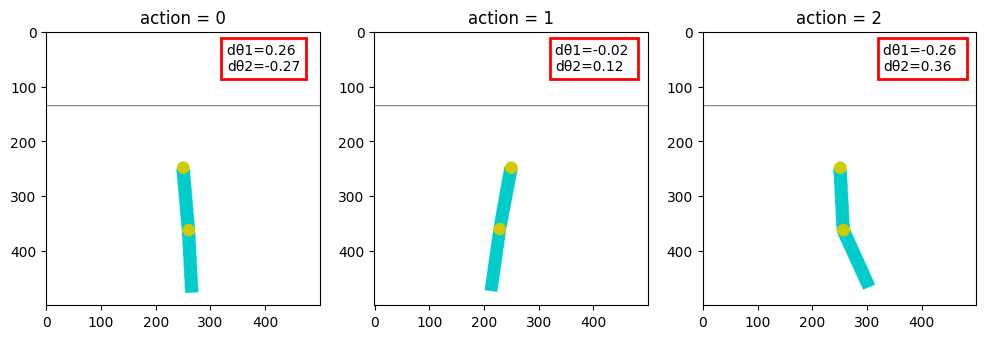

In [22]:
from policy_distillation.render import render_acrobot as render_fn

fig, ax = plt.subplots(1,n_actions, figsize=(12,8))

for i, synth_state in enumerate(final_dataset):
    img = render_fn(synth_state, env_params)
    ax[i].imshow(img, label="hello")
    ax[i].set_title(f"action = {action_labels[i]}")
    
    theta_dot1 = synth_state[-2].item()
    theta_dot2 = synth_state[-1].item()
    
    print(synth_state)
    
#     ax[i].set_xticks([0, 600/2, 600], [-4.8, 0, 4.8])
    ax[i].text(330, 70, f"dθ1={theta_dot1:.2f} \ndθ2={theta_dot2:.2f}", bbox=dict(fill=False, edgecolor='red', linewidth=2))

## TODO:

1. Investigate nan / fitness computation for CartPole
    - Division by zero if episodes not done


## Generalization

In [12]:
width_list = [2,4,8,16,32,64,128,256,512,1024]
fit_list = {
            "relu" : [],
            "tanh" : []
           }
for width in width_list:
    new_config = config.copy()
    new_config["WIDTH"] = width
    new_config["UPDATE_EPOCHS"] = 10
    num_envs = 20
    
    fitness ={
            "relu" : -1,
            "tanh" : -1
           }
    
    for activation in ["relu", "tanh"]:
        new_config["ACTIVATION"] = activation

        final_dataset # Given
        action_labels # Given

        new_train_fn = make_train(new_config)

        def new_BC_train(rng_input, dataset):
            out = new_train_fn(dataset, action_labels, rng_input)
            return out  # ["metrics"]['returned_episode_returns'].mean()

        vmapped_BC_train = jax.jit(jax.vmap(new_BC_train, in_axes=(0, None)))

        rng, rng_new = jax.random.split(rng)
        rng_batch = jax.random.split(rng_new, num_envs)

        out_new = vmapped_BC_train(rng_batch, final_dataset)

        returns = out_new["metrics"]["returned_episode_returns"]  # dim=(popsize, rollout_news, num_steps, num_envs)
        dones = out_new["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
        fitness[activation] = (returns * dones).sum(axis=(-1,-2)) / dones.sum(axis=(-1,-2))  # fitness, dim = (popsize)

        bc_loss = out_new['metrics']['bc_loss'][:,-1]

        fit_list[activation].append(fitness[activation])
    
    print(f"Width {width} : fitness (relu)={fitness['relu'].mean():.1f} +/- {fitness['relu'].std():.1f}, "
         + f"fitness (tanh)={fitness['tanh'].mean():.1f} +/- {fitness['tanh'].std():.1f}")
    

Width 2 : fitness (relu)=-386.9 +/- 163.4, fitness (tanh)=-262.8 +/- 188.9
Width 4 : fitness (relu)=-253.6 +/- 172.7, fitness (tanh)=-168.4 +/- 155.2
Width 8 : fitness (relu)=-156.7 +/- 112.7, fitness (tanh)=-93.9 +/- 22.6
Width 16 : fitness (relu)=-85.9 +/- 3.8, fitness (tanh)=-91.3 +/- 33.0
Width 32 : fitness (relu)=-86.5 +/- 3.0, fitness (tanh)=-97.8 +/- 53.8
Width 64 : fitness (relu)=-88.6 +/- 3.1, fitness (tanh)=-88.1 +/- 5.6
Width 128 : fitness (relu)=-90.2 +/- 5.4, fitness (tanh)=-131.5 +/- 77.5
Width 256 : fitness (relu)=-91.7 +/- 3.5, fitness (tanh)=-115.6 +/- 99.7
Width 512 : fitness (relu)=-89.2 +/- 4.1, fitness (tanh)=-86.1 +/- 8.4
Width 1024 : fitness (relu)=-122.3 +/- 79.6, fitness (tanh)=-179.4 +/- 150.8


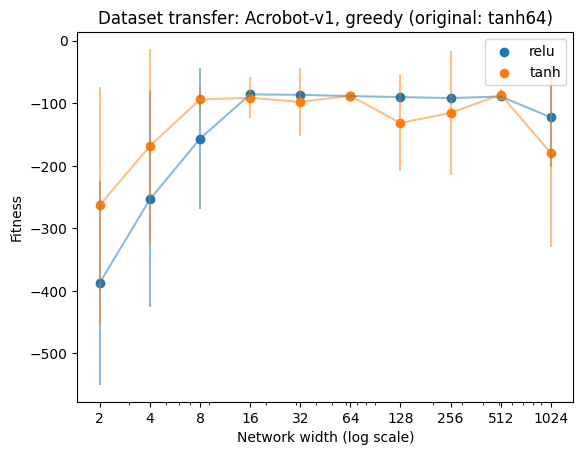

In [13]:
for activation, act_fit_list in fit_list.items():
    plt.scatter(width_list, [x.mean() for x in act_fit_list], label=activation)

    means = jnp.array([x.mean() for x in act_fit_list])
    stds = jnp.array([x.std() for x in act_fit_list])

    plt.errorbar(width_list, means, stds, alpha=0.5)
plt.ylabel("Fitness")
plt.xlabel("Network width (log scale)")
plt.xscale("log")
plt.xticks(width_list, width_list)

act = "greedy" if config["GREEDY_ACT"] else "softmax"
plt.title(f"Dataset transfer: {config['ENV_NAME']}, {act} (original: {config['ACTIVATION']}{config['WIDTH']})")
plt.legend()
plt.show()